In [38]:
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder
import numpy as np
from diffusers import UNet2DModel, DDPMScheduler
import lightning as L
from torchvision.datasets import MNIST

import torch
from torch import optim, nn, utils
from torchvision import transforms
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning import LightningModule, Trainer

In [40]:
mnist_root = Path.cwd().parent / "data" / "MNIST"

data_root_path = (
    Path.cwd() / "data" / "four_genre_posters_updated" / "four_genre_posters_updated"
)
IMAGE_SIZE = 32

transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

dataset = ImageFolder(data_root_path, transform=transform)

# dataset = MNIST(mnist_root, download=True, transform=transform)

if isinstance(dataset, ImageFolder):
    class_to_idx = dataset.find_classes(data_root_path)[0]
elif isinstance(dataset, MNIST):
    class_to_idx = {x: x for x in range(0, 10)}

FileNotFoundError: [Errno 2] No such file or directory: '/home/john/mp/diffusion-movie-posters/data/four_genre_posters_updated/four_genre_posters_updated'

9


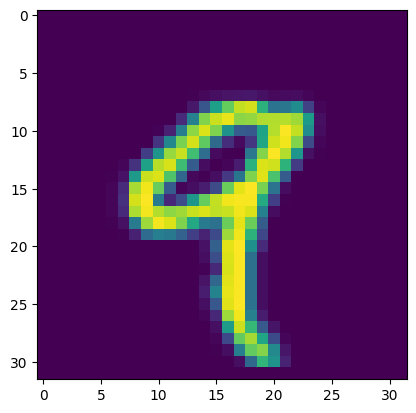

In [3]:
image, target = dataset[4]
print(target)

plt.imshow(image.permute((1, 2, 0)))

## Define the Network

In [24]:
class PosterGeneratorNetwork(L.LightningModule):
    def __init__(
        self,
        image_size: int,
        class_embedding_size: int,
        num_classes: int,
        num_timesteps: int,
    ):
        super(PosterGeneratorNetwork, self).__init__()

        self._image_size = image_size
        self._num_timesteps = num_timesteps

        self._class_embedding = nn.Embedding(num_classes, class_embedding_size)

        self._model = UNet2DModel(
            sample_size=image_size,
            in_channels=1 + class_embedding_size,
            out_channels=1,
            block_out_channels=(32, 64, 64),
            down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
            up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
        )

        self._noise_scheduler = DDPMScheduler(
            num_train_timesteps=self._num_timesteps, beta_schedule="squaredcos_cap_v2"
        )

        self._loss_fcn = nn.MSELoss()

    def forward(self, x, t, class_idx):

        class_conditioning = self._class_embedding(class_idx)

        class_conditioning = class_conditioning.reshape(
            (*class_conditioning.shape, 1, 1)
        ).expand((*class_conditioning.shape, *x.shape[2:]))

        image_input = torch.cat((x, class_conditioning), dim=1)

        return self._model(image_input, t).sample

    def training_step(self, batch, batch_idx):

        images, labels = batch

        noise = torch.randn_like(images).to(self.device)

        timesteps = (
            torch.randint(0, self._num_timesteps - 1, (images.shape[0],))
            .long()
            .to(self.device)
        )

        noisy_x = self._noise_scheduler.add_noise(images, noise, timesteps)

        pred = self(noisy_x, timesteps, labels)

        loss = self._loss_fcn(pred, noise)

        return {"loss": loss}

    def generate_images(self, labels: torch.Tensor | list):
        if isinstance(labels, list):
            labels = torch.Tensor(labels)

        labels = labels.long().to(self.device)

        x = torch.randn(labels.shape[0], 1, self._image_size, self._image_size).to(
            self.device
        )

        for indx, t in enumerate(self._noise_scheduler.timesteps):
            with torch.no_grad():
                residual = self(x, t, labels)

            x = self._noise_scheduler.step(residual, t, x).prev_sample

        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


class_embedding_size = 4
num_timesteps = 1000

task = PosterGeneratorNetwork(
    image_size=IMAGE_SIZE,
    class_embedding_size=class_embedding_size,
    num_classes=len(class_to_idx),
    num_timesteps=num_timesteps,
)

In [39]:
def plot_images(images, labels):
    fig, ax = plt.subplots(images.shape[0], figsize=(16, 16))

    images = images.detach().cpu()

    images -= images.min(dim=2, keepdim=True).values.min(dim=3, keepdim=True).values
    images /= images.max(dim=2, keepdim=True).values.max(dim=3, keepdim=True).values

    for image, ax, label in zip(images, ax, labels):
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(label)

    return fig


class GenerateImagesCallback(L.Callback):
    def __init__(self, every_n_epoch: int):
        super(GenerateImagesCallback, self).__init__()
        self._every_n_epoch = every_n_epoch
        self._counter = 0

        self._labels = [0, 1, 2, 3]

    def on_train_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        self._counter += 1

        if self._counter % self._every_n_epoch == 0:
            # Create image
            images = pl_module.generate_images(self._labels)

            fig = plot_images(images, self._labels)

            images_dir = Path(pl_module.logger.log_dir) / "images"
            images_dir.mkdir(exist_ok=True, parents=True)

            fig.savefig(images_dir / f"images_{self._counter}.png")


generate_images_callback = GenerateImagesCallback(every_n_epoch=1)
checkpoint_callback = ModelCheckpoint(every_n_epochs=10)

In [32]:
batch_size = 16
dataloader = utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
A = next(iter(dataloader))

In [33]:
trainer = L.Trainer(
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    min_epochs=1,
    max_epochs=50,
    callbacks=[generate_images_callback, checkpoint_callback],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type        | Params | Mode 
---------------------------------------------------------
0 | _class_embedding | Embedding   | 40     | train
1 | _model           | UNet2DModel | 1.6 M  | train
2 | _loss_fcn        | MSELoss     | 0      | train
---------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.497     Total estimated model params size (MB)
220       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

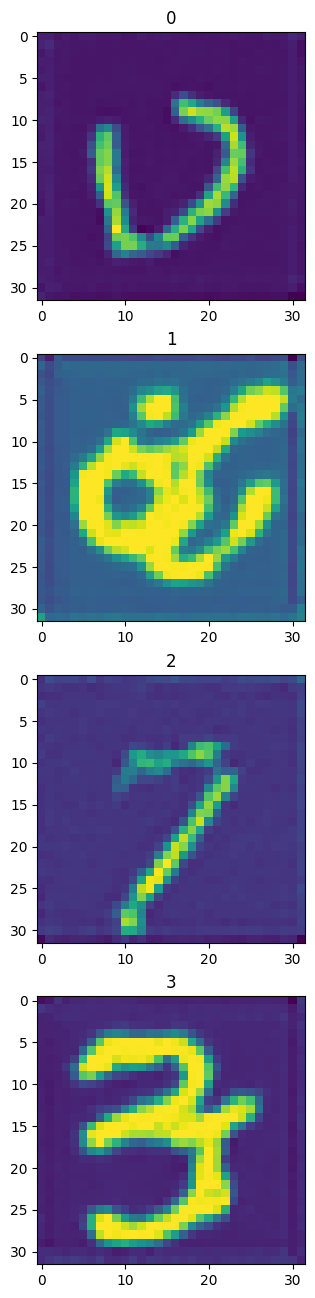

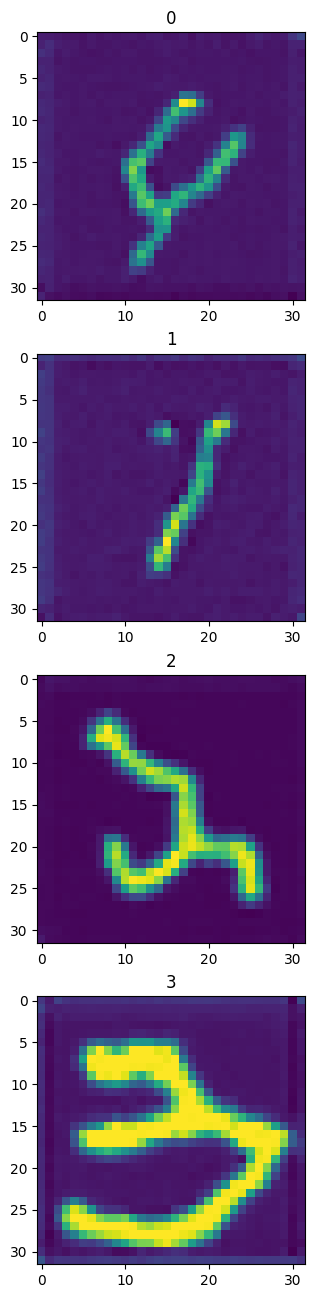

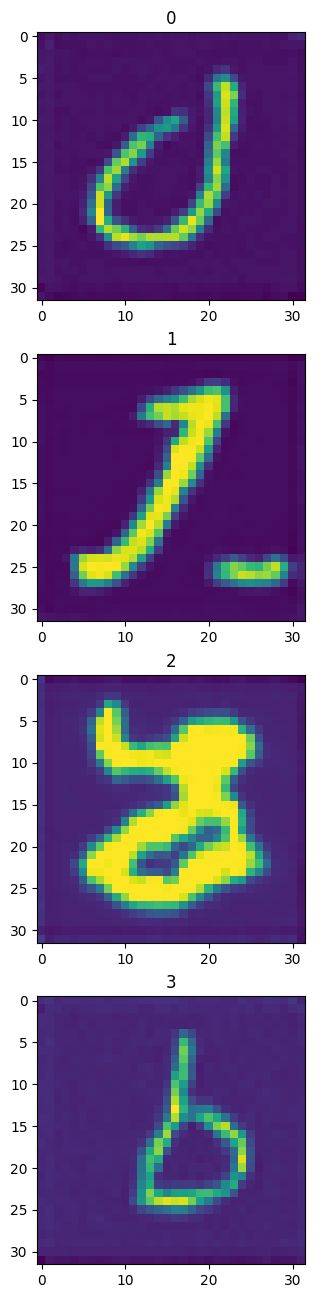

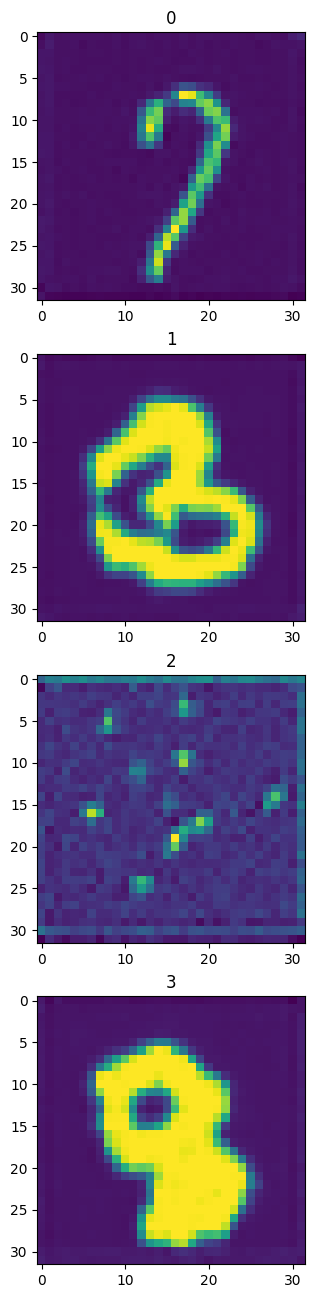

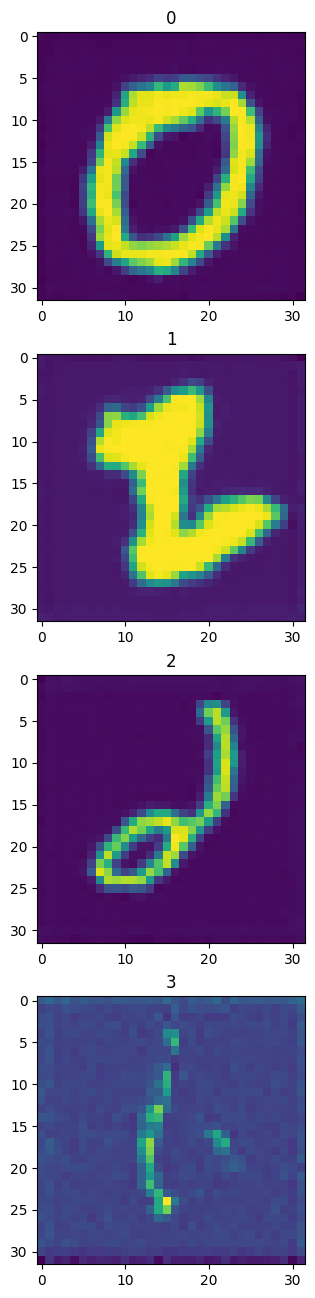

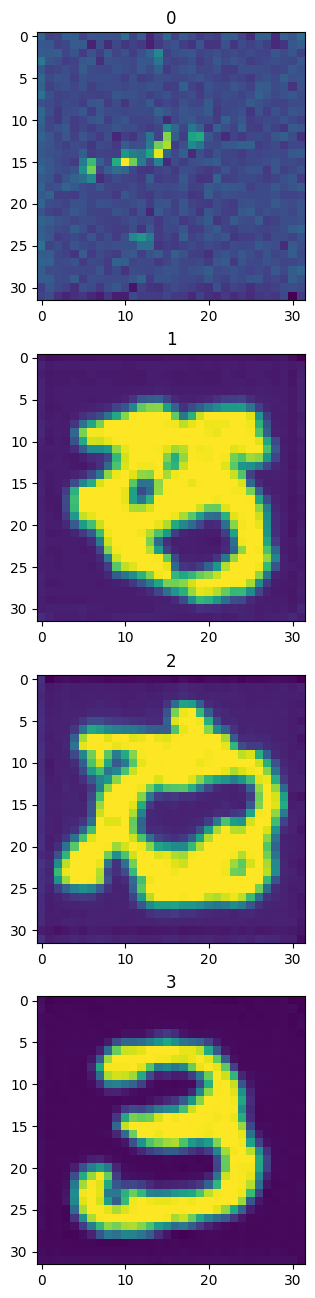

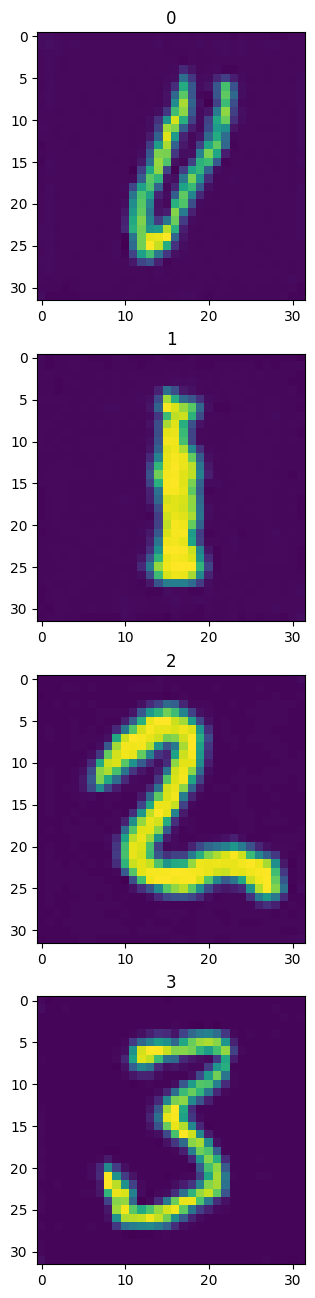

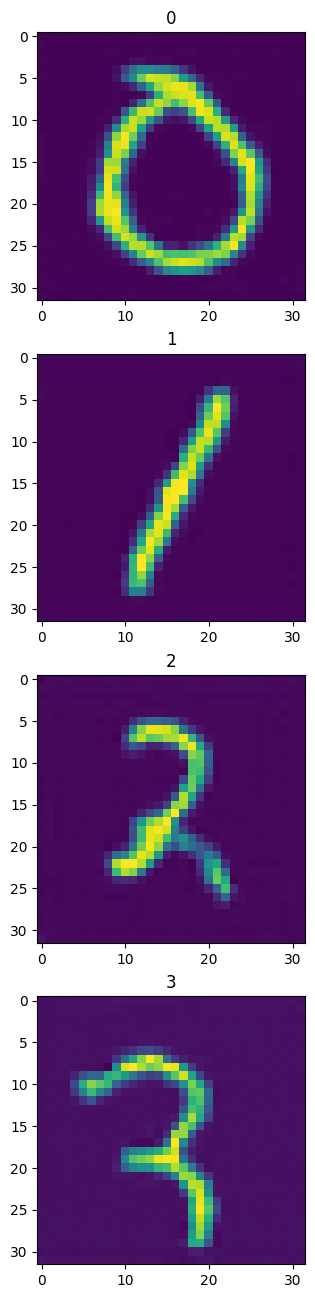

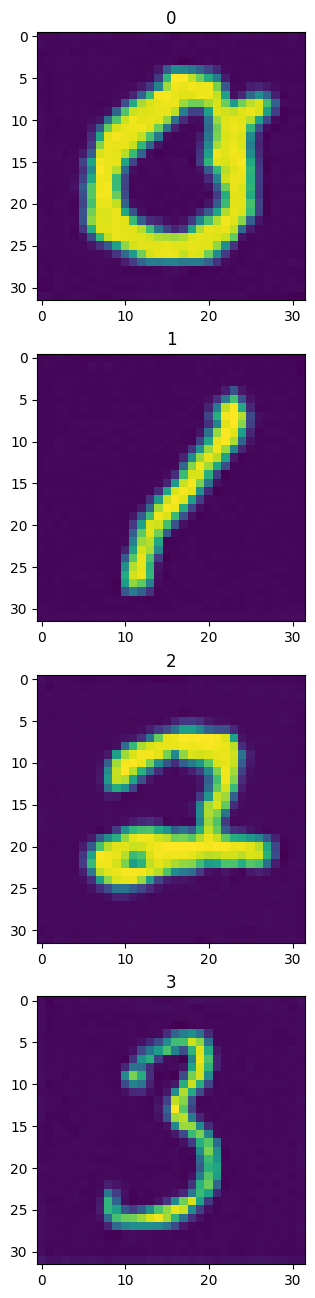

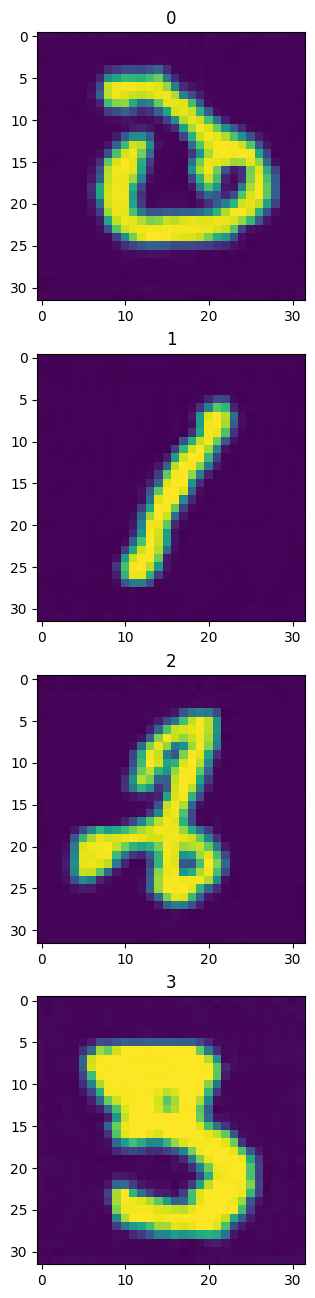

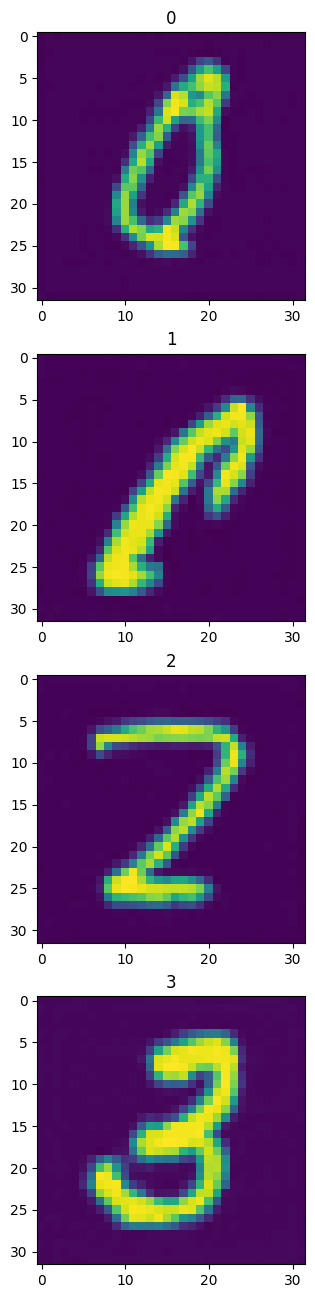

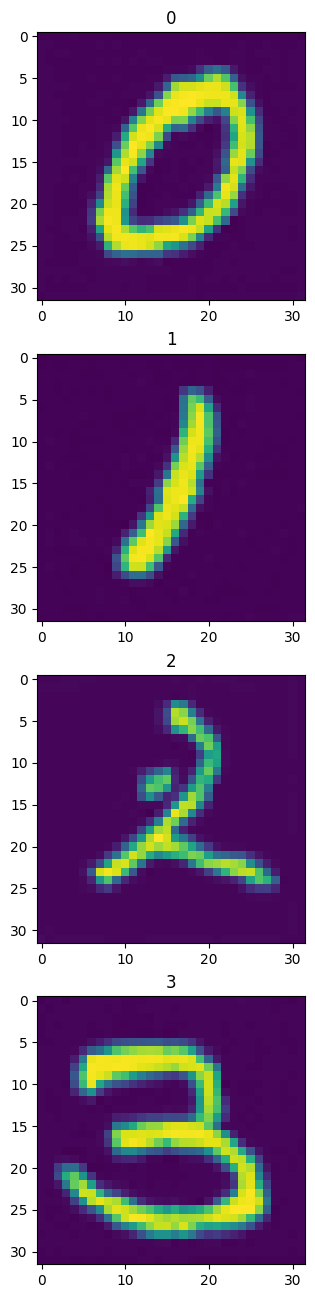

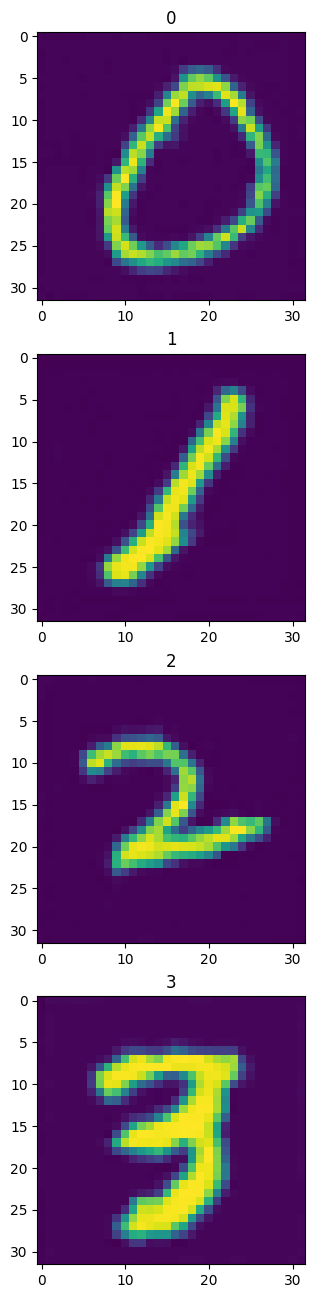

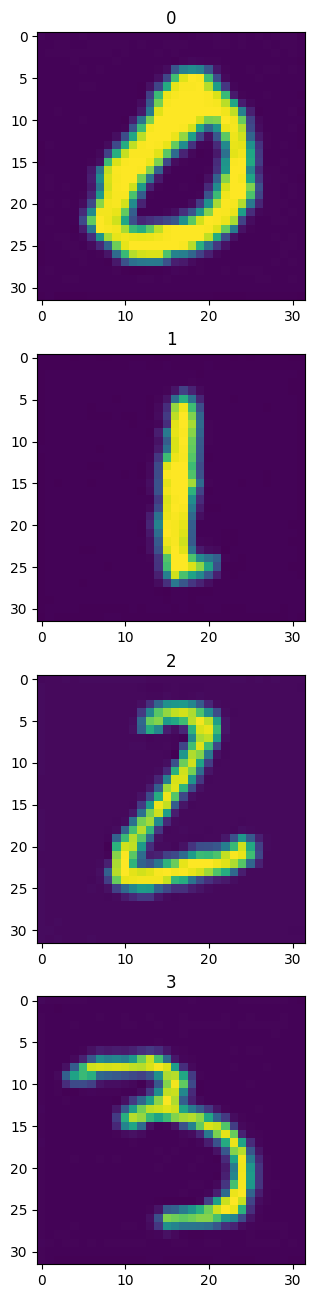

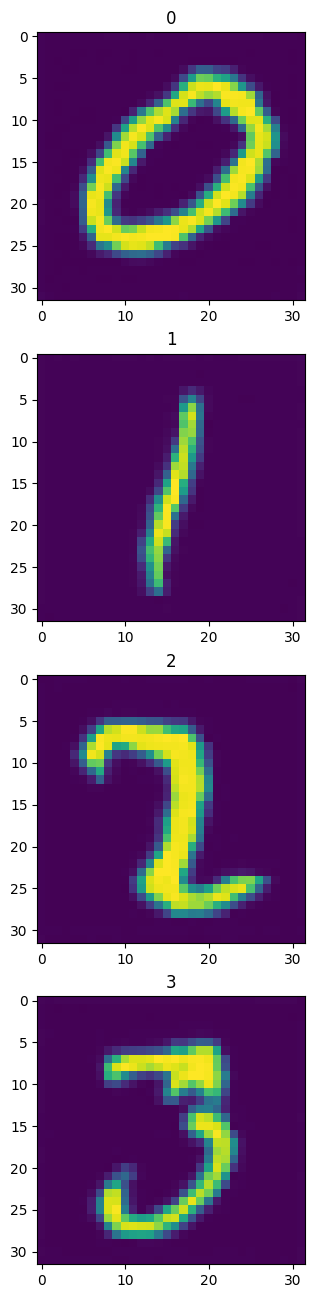

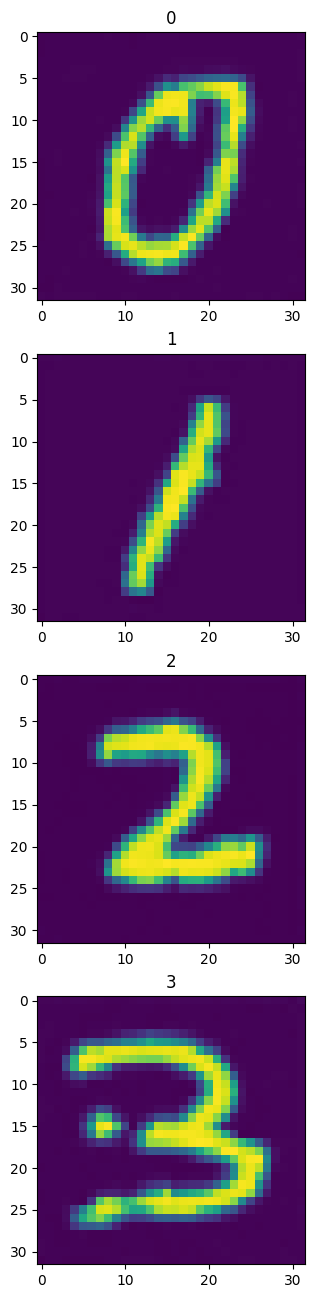

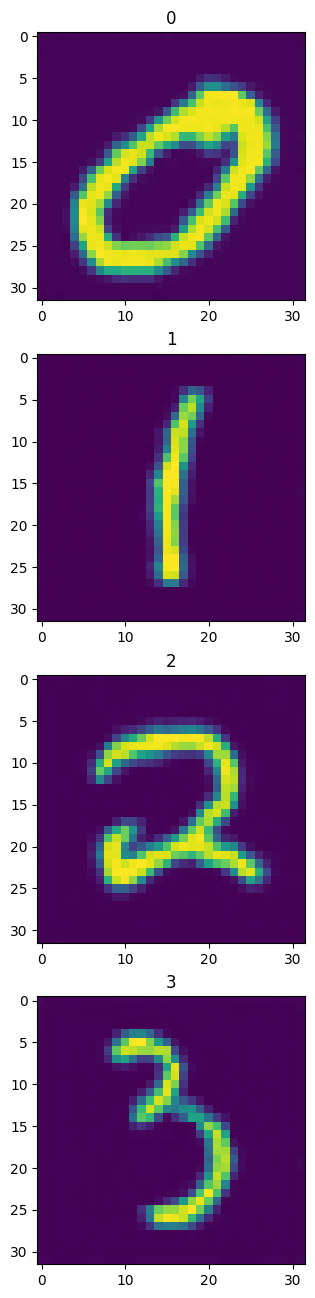

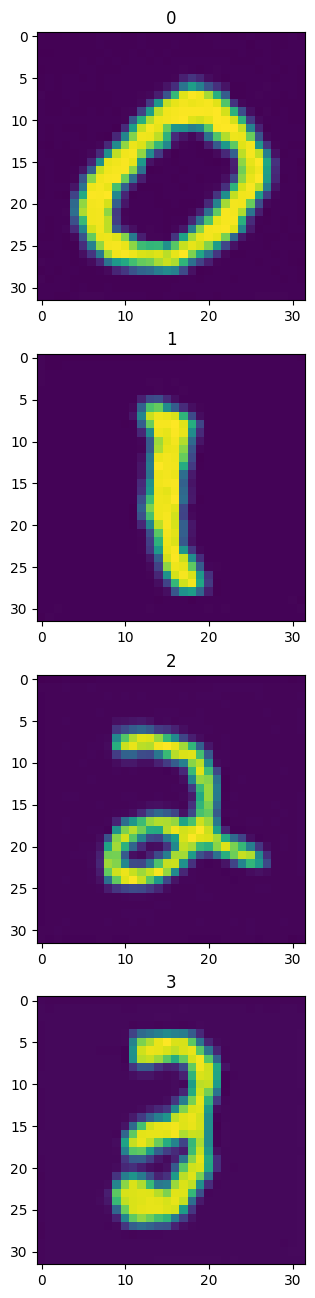

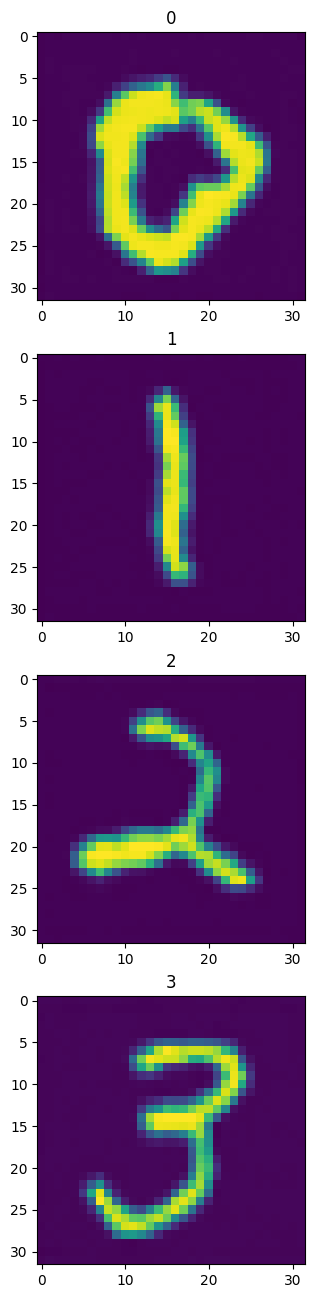

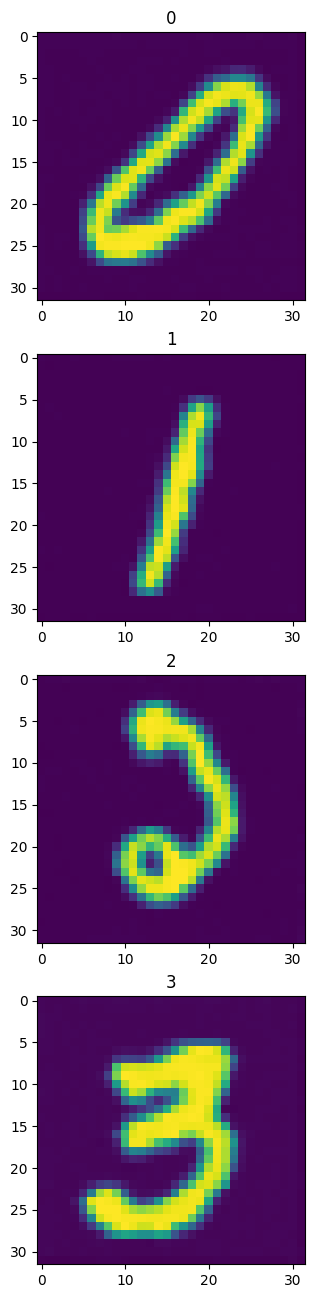

In [34]:
trainer.fit(task, dataloader)